# 3D_HOUSES

## Import all libraries

In [3]:
from glob import glob
from typing import Tuple, List
import natsort
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import geopandas as gpd
import rasterio
import rioxarray as rxr
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union

%matplotlib inline

## Global Variables

In [4]:
DSM_path = "/Volumes/Samsung T7/DSM/**/*.tif"
DTM_path =  "/Volumes/Samsung T7/DTM/**/*.tif"

shp_paths = ["/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_CaBu.shp", "/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_ReBu.shp"]

property = {}

## Create a dictionary of GTiff's paths and bounds

In [5]:
def load_data(DSM_path:str, DTM_path:str) -> dict:
    
    data = {}
    data['DSM_list'] = natsort.natsorted([file for file in glob(DSM_path, recursive=True)])
    data['DTM_list'] = natsort.natsorted([file for file in glob(DTM_path, recursive=True)])
    data['bounds'] = []
    
    for path in data['DSM_list']:
        with rasterio.open(path, driver="GTiff") as tif:
            data['bounds'].append(np.array(tif.bounds))

    return data

In [6]:
data = load_data(DSM_path, DTM_path)

## Fetching the L_72 coordinates from the API with address

In [7]:
def fetch_coord(address:str)  -> Point:
    pass

In [8]:
coord = Point(104994.91, 192612.04) #https://loc.geopunt.be/v4/Location?q=Sint-Pietersplein%209,gent
# coord = Point(104942.33, 192558.11) # https://loc.geopunt.be/v4/Location?q=Sint-Pietersplein%2016,gent
# coord = Point(152898.38, 212199.67) # https://loc.geopunt.be/v4/Location?q=Lange%20Nieuwstraat%2073,Antwerpen

## Find the relevant GTiff file containing the coordinates

In [9]:
def find_tif(data:dict, coord:Point) -> Tuple[str]:
    x, y = coord.xy
    for tif_index, bounds in enumerate(data['bounds']):
        x_min, y_min, x_max, y_max = bounds
        if (x_min < x < x_max) and (y_min < y < y_max):
            return tif_index

In [10]:
tif_index = find_tif(data, coord)

## Find the polygon containing the coordinates

In [11]:
def find_polygon(coord:Point, shp_paths:List[str]):

    for path in shp_paths:
        try:
            check_poly = gpd.read_file(path, mask=coord).geometry[0]
            polys = [poly for poly in gpd.read_file(path, mask=coord).geometry]
            poly = cascaded_union(polys)
            break
        except:
            continue
    return poly

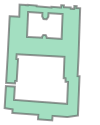

In [12]:
poly = find_polygon(coord, shp_paths)
poly

## Crop DSM & DTM

In [13]:
def crop_tif(data, tif_index, poly, shape_cut=False):
    
    DSM = rxr.open_rasterio(data['DSM_list'][tif_index],masked=True)
    DTM = rxr.open_rasterio(data['DTM_list'][tif_index],masked=True)

    left, bottom, right, top = poly.bounds
    DSM_clip = DSM.rio.clip_box(left, bottom, right, top)
    DTM_clip = DTM.rio.clip_box(left, bottom, right, top)

    if shape_cut:
        DSM_clip = DSM_clip.rio.clip([poly.__geo_interface__])
        DSM_clip = np.nan_to_num(DSM_clip, nan=0)

        DTM_clip = DTM_clip.rio.clip([poly.__geo_interface__])
        DTM_clip = np.nan_to_num(DTM_clip, nan=0)
    
    DSM.close()
    DTM.close()
    
    return DSM_clip, DTM_clip

In [14]:
DSM_clip, DTM_clip = crop_tif(data, tif_index, poly, shape_cut=False)

## Create CHM from DSM & DTM

In [15]:
def CHMer(DSM_clip, 
          DTM_clip):
    return DSM_clip - DTM_clip

In [16]:
CHM = CHMer(DSM_clip, DTM_clip)

## Outputing property's information

In [17]:
property["Max_height"] = np.max(CHM.data)
property["Estimated surface area"] = poly.area * 0.7 # Roughly 70% of built-area is living area https://www.quora.com/How-do-I-calculate-the-number-of-floors-to-be-built
property["Estimated Max number of floors"] = int(property["Max_height"] / 3.3)
property["Upper limit of living area"] = property["Estimated Max number of floors"] * property["Estimated surface area"]
property

{'Max_height': 29.744654,
 'Estimated surface area': 3237.984391036394,
 'Estimated Max number of floors': 9,
 'Upper limit of living area': 29141.859519327543}

## 3D Rendering

In [18]:
from mayavi import mlab

In [19]:
def render_3D(CHM_clip):
    arr = CHM_clip.squeeze().data
    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
    surf = mlab.surf(arr)
    mlab.zlabel("Height")
    mlab.show()

## 3D Rendering inline

In [20]:
# from mayavi import mlab

In [21]:
#mlab.init_notebook()
#def render_3D_inline(CHM_clip):
#    arr = CHM_clip.squeeze().data
#    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
#    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
#    surf = mlab.surf(arr)
#    mlab.zlabel("Height")
#    return surf

## Enter an address

In [22]:
output = widgets.Output()

address = widgets.Dropdown(
    options=['Sint-Pietersplein 9 Gent 9000', 'Sint-Pietersplein 16 Gent 9000', 'Lange Nieuwstraat 73 Antwerpen 2000'],
    value='Sint-Pietersplein 9 Gent 9000',
    description='Address:',
    disabled=False,
)

button = widgets.Button(
    description='3D Plot',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)

def test(output):
    render_3D(CHM)
    
button.on_click(test)

items = [address, button]
widgets.Box(items)

Box(children=(Dropdown(description='Address:', options=('Sint-Pietersplein 9 Gent 9000', 'Sint-Pietersplein 16…

In [23]:
property

{'Max_height': 29.744654,
 'Estimated surface area': 3237.984391036394,
 'Estimated Max number of floors': 9,
 'Upper limit of living area': 29141.859519327543}